In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Importing saved data, analyzed on LSTM model code

In [8]:
df=pd.read_csv('clean_df_MULTICLASS.csv')

In [12]:
df.drop(columns='Unnamed: 0', inplace=True)

In [13]:
df

,CAT1,ORD1,ORD2,ORD3,ORD4,ORD5,ORD6,ORD7,ORD8,ORD9,ORD10,ORD11,ORD12,PRICE
0,0,0.00632,18.0,2.31,0.538,6.575,65.2,4.090,1,296,15.3,396.90,4.98,2
1,0,0.02731,0.0,7.07,0.469,6.421,78.9,4.967,2,242,17.8,396.90,9.14,1
2,0,0.02729,0.0,7.07,0.469,7.185,61.1,4.967,2,242,17.8,392.83,4.03,2
3,0,0.03237,0.0,2.18,0.458,6.998,45.8,6.062,3,222,18.7,394.63,2.94,2
4,0,0.06905,0.0,2.18,0.458,7.147,54.2,6.062,3,222,18.7,396.90,5.33,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,0,0.06263,0.0,11.93,0.573,6.593,69.1,2.479,1,273,21.0,391.99,9.67,1
1008,0,0.04527,0.0,11.93,0.573,6.120,76.7,2.288,1,273,21.0,396.90,9.08,1
1009,0,0.06076,0.0,11.93,0.573,6.976,91.0,2.168,1,273,21.0,396.90,5.64,2
1010,0,0.10959,0.0,11.93,0.573,6.794,89.3,2.389,1,273,21.0,393.45,6.48,1


### Train,test,split

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:13],df.iloc[:,-1],test_size=0.2,random_state=42)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((809, 13), (203, 13), (809,), (203,))

### Making k-1 dummy variable of 'ORD8' categorical column using OneHotEncoder since nominal data

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
transformer = ColumnTransformer(transformers=[
    ('tnf1' ,OneHotEncoder(sparse_output=False,drop='first'),['ORD8'])
     ],remainder='passthrough')

In [18]:
X_train_new = transformer.fit_transform(X_train)
X_test_new = transformer.transform(X_test)

In [19]:
X_train_new.shape, X_test_new.shape, y_train.shape, y_test.shape

((809, 20), (203, 20), (809,), (203,))

### Normalizing data

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_new)
X_test_scaled = scaler.transform(X_test_new)

### Reshape data for CNN [samples, features, channels]

In [21]:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

### CNN Model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax')) 

In [24]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 128)            24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 128)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 dense (Dense)               (None, 50)                1

### callbacks

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('best_model_CNN_multiclass.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

### Train the model

In [26]:
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[checkpoint, early_stopping])

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.9756 - accuracy: 0.5147
Epoch 1: val_loss improved from inf to 0.89123, saving model to best_model_CNN_multiclass.h5
21/21 [==============================] - 22s 53ms/step - loss: 0.9756 - accuracy: 0.5147 - val_loss: 0.8912 - val_accuracy: 0.5864
Epoch 2/100
16/21 [=====================>........] - ETA: 0s - loss: 0.8436 - accuracy: 0.5938
Epoch 2: val_loss improved from 0.89123 to 0.79368, saving model to best_model_CNN_multiclass.h5
21/21 [==============================] - 0s 13ms/step - loss: 0.8221 - accuracy: 0.6151 - val_loss: 0.7937 - val_accuracy: 0.6358
Epoch 3/100
20/21 [===========================>..] - ETA: 0s - loss: 0.7574 - accuracy: 0.6719
Epoch 3: val_loss improved from 0.79368 to 0.74749, saving model to best_model_CNN_multiclass.h5
21/21 [==============================] - 0s 15ms/step - loss: 0.7575 - accuracy: 0.6723 - val_loss: 0.7475 - val_accuracy: 0.6481
Epoch 4/100
15/21 [==================

In [28]:
import tensorflow as tf
best_model = tf.keras.models.load_model('best_model_CNN_multiclass.h5')

In [29]:
evaluation = best_model.evaluate(X_test_reshaped, y_test)
print(f"Evaluation Results - Loss: {evaluation[0]}, Accuracy: {evaluation[1]}")

7/7 [==============================] - 1s 45ms/step - loss: 0.5041 - accuracy: 0.8719
Evaluation Results - Loss: 0.5041300654411316, Accuracy: 0.871921181678772


In [30]:
y_pred = best_model.predict(X_test_reshaped)
y_pred_classes = y_pred.argmax(axis=1)

7/7 [==============================] - 0s 4ms/step


In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy Score: {accuracy*100}")

Accuracy Score: 87.192118226601


### Classification report

In [35]:
report = classification_report(y_test, y_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.83      0.86        65
           1       0.82      0.91      0.86        74
           2       0.92      0.88      0.90        64

    accuracy                           0.87       203
   macro avg       0.88      0.87      0.87       203
weighted avg       0.88      0.87      0.87       203



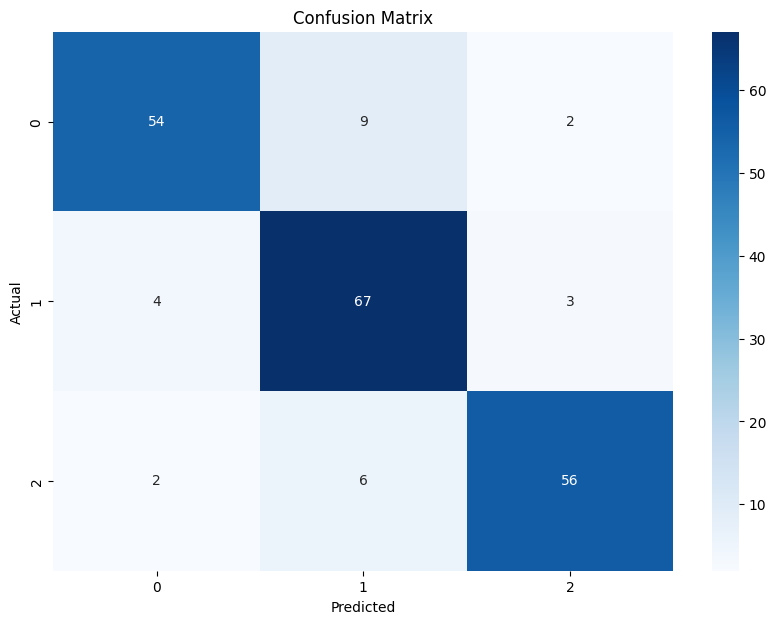

In [36]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()